In [1]:
import h5py, sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
path_to_data = "../../data/sparse/" # scratch/sparse on Maxwell
path_to_aux = "../../data/aux/" # scratch/benedikt/aux on Maxwell
path_to_geometry = "../../geometry/"
path_to_recons = "../../data/recons/"
path_to_lcls = "../../data/lcls/"

## LCLS data

In [29]:
filename = path_to_lcls + "original-avg_image.h5"
filename = path_to_lcls + "subtracted-avg_image.h5"

In [36]:
with h5py.File(filename, 'r') as f:
    volume = np.fft.fftshift(f['real'][:])

['detector_distance', 'imag', 'image_center', 'lambda', 'mask', 'num_dimensions', 'phased', 'pixel_size', 'real', 'scaled', 'shifted', 'version']


In [28]:
import mrcfile
with mrcfile.new(filename[:-3] + '.mrc', overwrite=True) as mrc:
    mrc.set_data(volume.astype(np.float32))

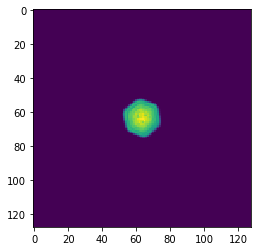

In [33]:
plt.imshow(volume[:,:,128//2])

In [57]:
photon_energy_lcls = 1.2 # keV
wavelength_lcls = 1240. / photon_energy_lcls / 1e3 # nm
max_radius_lcls = 39 # mm
distance_lcls = 732 # mm
dx_lcls = .5 / ((2*np.sin(np.arctan2(max_radius_lcls, distance_lcls)/2.)) / wavelength_lcls) # nm

In [58]:
print("For the LCLS data, the real space voxels have a size of %.2f nm" %dx_lcls)

For the LCLS data, the real space voxels have a size of 9.71 nm


## XFEL data

In [69]:
photon_energy_xfel = 6.01 # keV
wavelength_xfel = 1240. / photon_energy_xfel / 1e3 # nm
boxsize_xfel = 145
max_radius_xfel = boxsize_xfel * 0.2 / 2. # mm
distance_xfel = 705 # mm
dx_xfel = .5 / ((2*np.sin(np.arctan2(max_radius_xfel, distance_xfel)/2.)) / wavelength_xfel) # nm

In [60]:
print("For the XFEL data, the real space voxels should have a size of %.2f" %dx_xfel)

For the XFEL data, the real space voxels should have a size of 5.02


## Interpolate the LCLS data to match the XFEL voxel size

In [61]:
import scipy.ndimage as ndimage

In [145]:
new_volume = ndimage.zoom(volume, dx_lcls/dx_xfel, order=1, mode='nearest')
c = (new_volume.shape[0] - boxsize_xfel)/2.
l = int(np.floor(c))
r = int(np.ceil(c))
new_volume = new_volume[l:-r,l:-r,l:-r]

In [146]:
n = new_volume.shape[0]
xx,yy,zz = np.meshgrid(np.arange(n)-n//2, np.arange(n)-n//2, np.arange(n)-n//2, indexing='ij')
rr = np.sqrt(xx**2 + yy**2 + zz**2)
mm = (rr < 35).astype(np.float64)
mask = ndimage.gaussian_filter(mm,1)

In [147]:
new_volume = np.fft.ifftn(np.fft.ifftshift(np.fft.fftshift(np.fft.fftn(new_volume)) * mask)).real

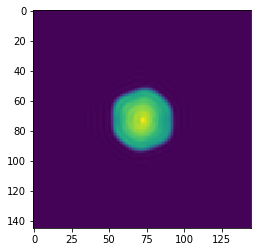

In [148]:
plt.imshow(new_volume[new_volume.shape[0]//2].real)
plt.show()

In [154]:
import mrcfile
with mrcfile.new(filename[:-3] + '_interp' + '.mrc', overwrite=True) as mrc:
    mrc.set_data(new_volume.astype(np.float32))

## Calculate intensity volume

In [150]:
intensity = np.fft.fftshift(np.abs(np.fft.fftn(new_volume))**2)

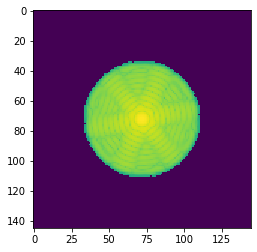

In [153]:
plt.imshow(intensity[:,:,72], norm=colors.LogNorm())

In [155]:
with mrcfile.new(path_to_lcls + 'intensities_interp.mrc', overwrite=True) as mrc:
    mrc.set_data(intensity.astype(np.float32))

In [159]:
with h5py.File(path_to_recons + "init.h5", "w") as f:
    f["intens"] = intensity.astype("<f8").reshape(1,n,n,n) * 5e-9
    f['scale'] = np.ones(331436, dtype=np.int32)